In [1]:
import numpy as np 
import cv2 as cv 
from matplotlib import pyplot as plt 
import math

img = cv.imread('fisherman.jpg') #load image 
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 

In [2]:
D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8 
der_x = cv.filter2D(img_gray, cv.CV_32F, D_x) # CV_32F is used to store negative values 

In [3]:
D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8 
der_y = cv.filter2D(img_gray, cv.CV_32F, D_y) # CV_32F is used to store negative values 

In [4]:
height, width = img_gray.shape 
ori_img_gray = np.zeros((height, width), np.float32) # gradient orientation of img_gray

for i in range(0, height): 
    for j in range(0, width): 
        if (der_x[i, j] == 0 and der_y[i, j] == 0): 
            ori_img_gray[i, j] = math.inf
        else:
            ori_img_gray[i, j] = ((math.atan2(der_y[i, j], der_x[i, j]) * 180) / math.pi) + 90
            if ori_img_gray[i, j] < 0:
                ori_img_gray[i, j] += 360

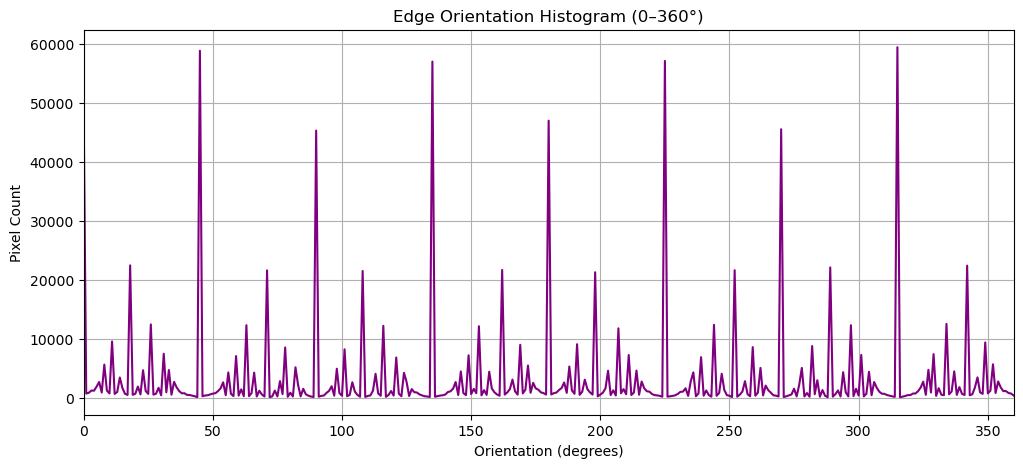

In [5]:
hist, bins = np.histogram(ori_img_gray, bins=361, range=(0, 360))

# Plot the histogram
plt.figure(figsize=(12, 5))
plt.plot(hist, color='purple')
plt.title('Edge Orientation Histogram (0–360°)')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Pixel Count')
plt.xlim([0, 360])
plt.grid(True)
plt.show()

In [6]:
img_empire = cv.imread('empire.jpg') #load image 
img_empire_gray = cv.cvtColor(img_empire, cv.COLOR_BGR2GRAY) 

In [7]:
D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8 
der_x = cv.filter2D(img_empire_gray, cv.CV_32F, D_x) # CV_32F is used to store negative values 

In [8]:
D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8 
der_y = cv.filter2D(img_empire_gray, cv.CV_32F, D_y) # CV_32F is used to store negative values 

In [9]:
height, width = img_empire_gray.shape 
ori_img_empire_gray = np.zeros((height, width), np.float32) # gradient orientation of img_empire_gray

for i in range(0, height): 
    for j in range(0, width): 
        if (der_x[i, j] == 0 and der_y[i, j] == 0): 
            ori_img_empire_gray[i, j] = math.inf
        else:
            ori_img_empire_gray[i, j] = ((math.atan2(der_y[i, j], der_x[i, j]) * 180) / math.pi) + 90
            if ori_img_empire_gray[i, j] < 0:
                ori_img_empire_gray[i, j] += 360

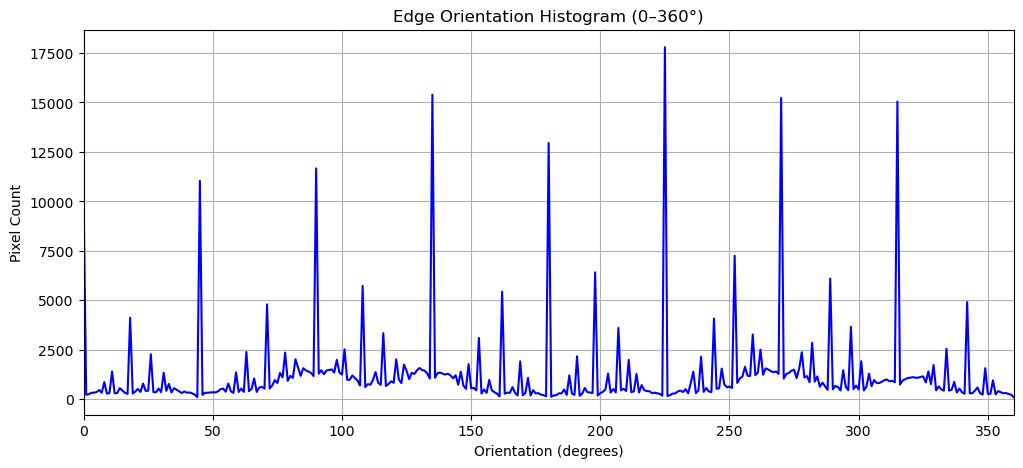

In [10]:
hist, bins = np.histogram(ori_img_empire_gray, bins=361, range=(0, 360))

# Plot the histogram
plt.figure(figsize=(12, 5))
plt.plot(hist, color='blue')
plt.title('Edge Orientation Histogram (0–360°)')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Pixel Count')
plt.xlim([0, 360])
plt.grid(True)
plt.show()

In [11]:
doc = cv.imread('doc.jpg', 0) # 2nd parameter is set to 0 to read grayscale image

In [12]:
threshold = 200 
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY) 

In [13]:
closing_se = np.ones((1, 15), int) # structuring element for closing 

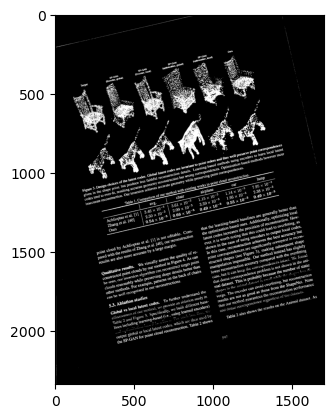

In [14]:
doc_bin = 255 - doc_bin # convert black/white to white/black
plt.imshow(doc_bin, 'gray') 

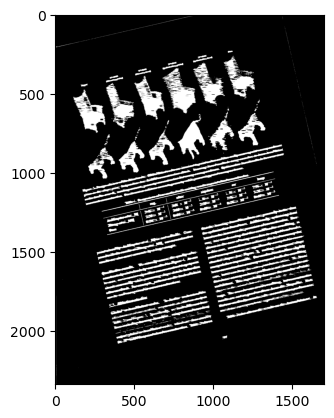

In [15]:
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se) 
plt.imshow(closing, 'gray') 

In [16]:
opening_se = np.ones((8, 8), int) # structuring element for opening 

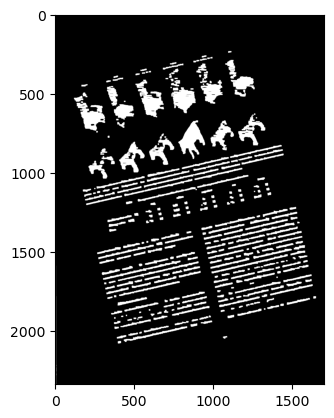

In [17]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se) 
plt.imshow(opening, 'gray') 

In [18]:
# connected component labelling 
num_labels, labels_im = cv.connectedComponents(opening) 

In [19]:
def ExtractConnectedComponents(num_labels, labels_im): 
    connected_components = [[] for i in range(0, num_labels)] 
    height, width = labels_im.shape 
    
    for i in range(0, height): 
        for j in range(0, width): 
            if labels_im[i, j] >= 0: 
                connected_components[labels_im[i, j]].append((j, i)) 
                
    return connected_components 

In [20]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

In [21]:
def FindOrientation(cc): 
    mx = 0 
    my = 0 
    mxx = 0 
    myy = 0 
    mxy = 0 
     
    for i in range(0, len(cc)): 
        mx += cc[i][0] # cc[i][0] is used to store the x coordinate of pixel cc[i] 
        my += cc[i][1] # cc[i][1] is used to store the y coordinate of pixel cc[i] 
    mx /= len(cc) 
    my /= len(cc) 
     
    for i in range(0, len(cc)): 
        dx = cc[i][0] - mx 
        dy = cc[i][1] - my 
        mxx += (dx * dx) 
        myy += (dy * dy) 
        mxy += (dx * dy) 
    mxx /= len(cc) 
    myy /= len(cc) 
    mxy /= len(cc) 
     
    theta = - math.atan2(2 * mxy, mxx - myy) / 2 
    return theta 

In [22]:
orientations = np.zeros(num_labels, np.float32) 
for i in range(0, num_labels): 
    orientations[i] = FindOrientation(connected_components[i])

In [23]:
import statistics 
orientation = statistics.median(orientations)

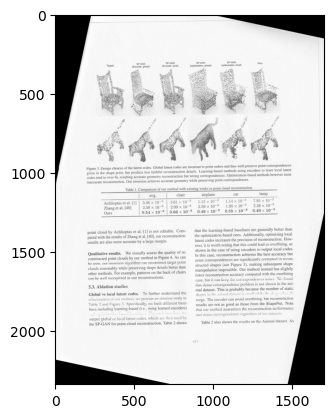

In [24]:
# rotate image 
height, width = doc.shape 
c_x = (width - 1) / 2.0 # column index varies in [0, width-1] 
c_y = (height - 1) / 2.0 # row index varies in [0, height-1] 
c = (c_x, c_y) # A point is defined by x and y coordinate 
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1) 
doc_deskewed = cv.warpAffine(doc, M, (width, height)) 
plt.imshow(doc_deskewed, 'gray')

In [25]:
doc_1 = cv.imread('doc_1.jpg', 0) # 2nd parameter is set to 0 to read grayscale image

In [26]:
threshold = 200 
ret, doc_1_bin = cv.threshold(doc_1, threshold, 255, cv.THRESH_BINARY) 

In [27]:
closing_se = np.ones((1, 15), int) # structuring element for closing 

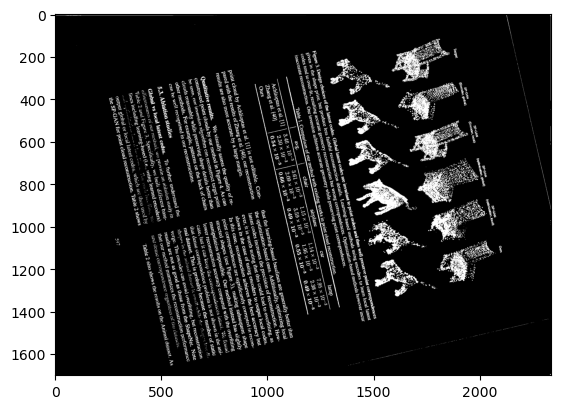

In [28]:
doc_1_bin = 255 - doc_1_bin # convert black/white to white/black
plt.imshow(doc_1_bin, 'gray') 

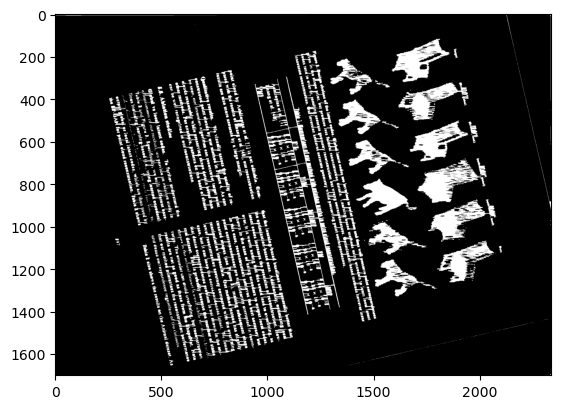

In [29]:
closing = cv.morphologyEx(doc_1_bin, cv.MORPH_CLOSE, closing_se) 
plt.imshow(closing, 'gray') 

In [30]:
opening_se = np.ones((8, 8), int) # structuring element for opening 

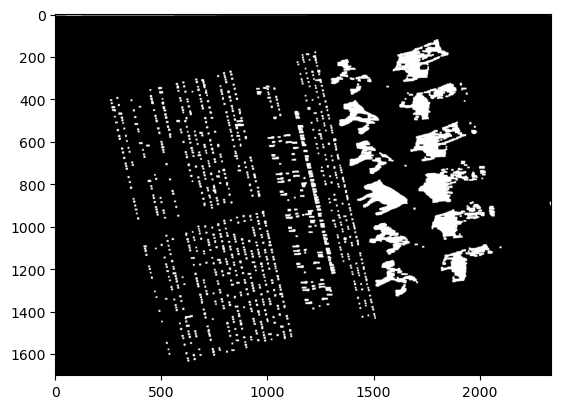

In [31]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se) 
plt.imshow(opening, 'gray') 

In [32]:
# connected component labelling 
num_labels, labels_im = cv.connectedComponents(opening) 

In [33]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

In [34]:
orientations = np.zeros(num_labels, np.float32) 
for i in range(0, num_labels): 
    orientations[i] = FindOrientation(connected_components[i])

In [35]:
orientation = statistics.median(orientations)

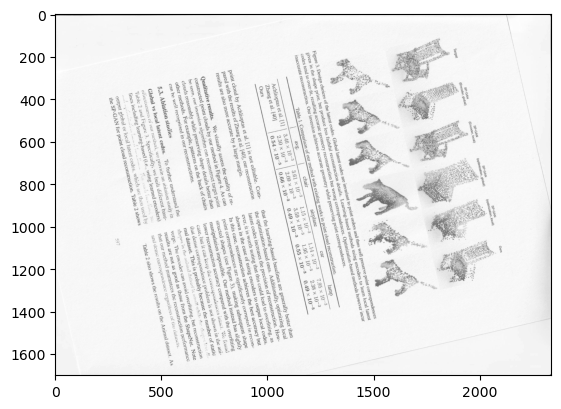

In [36]:
# rotate image 
height, width = doc_1.shape 
c_x = (width - 1) / 2.0 # column index varies in [0, width-1] 
c_y = (height - 1) / 2.0 # row index varies in [0, height-1] 
c = (c_x, c_y) # A point is defined by x and y coordinate 
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1) 
doc_1_deskewed = cv.warpAffine(doc_1, M, (width, height)) 
plt.imshow(doc_1_deskewed, 'gray')